<a href="https://colab.research.google.com/github/roaashosha/meteor-landing/blob/main/finalMeteor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Meteor Landing**
This project focuses on classifying meteorites based on their physical and chemical properties using machine learning. The goal is to predict the class (e.g., L6, H5, ,LL5, etc.) of a meteorite from features such as mass,denisty,fell or found,mag susceptibility and others.
Traditional meteorite classification is a time-consuming and complex process that often requires extensive laboratory analysis. However, speed is critical in this context—meteorites can undergo rapid changes when exposed to Earth's oxygen and environmental conditions, which may alter their original composition. This project aims to provide a fast and reliable classification method to minimize exposure time and preserve the meteorite's scientific value.

By leveraging machine learning, the system can assist scientists in making quicker initial assessments, guiding more detailed follow-up analyses and improving overall efficiency in meteoritics research.

**The notebook covers:**

* Data loading and cleaning
* statical data analysis
* Feature engineering, selection ,construction and preprocessing
* Handling class imbalance (e.g., using SMOTE)
* Building and evaluating classification models
* Creating a GUI or visualizations for predictions

### **Features:**
###  1. Mass  
**Feature:** `mass (g)`  
The weight of the meteorite in grams. Mass can influence classification—some meteorite types are typically heavier due to their composition.

### 2. Magnetic Susceptibility  
**Feature:** `mag_susc`  
Magnetic susceptibility indicates how much a material can be magnetized. It reflects metallic content, which is crucial for distinguishing between stony, iron, and stony-iron meteorites.

### 3. Density  
**Feature:** `density (g/cm³)`  
The meteorite’s density helps identify its type. For example, iron meteorites are denser than stony ones, making this a strong discriminating feature.

### 4. Iron and Nickel Content  
**Feature 1:** `Fe (%)`  
The percentage of iron in the meteorite. High Fe content usually suggests an iron or stony-iron class.

**Feature 2:** `Ni (%)`  
The percentage of nickel. Like Fe, Ni is abundant in iron meteorites and supports classification.

###  5. Geographic Coordinates  
**Feature 1:** `longitude`  
The east–west position of the meteorite's location. May offer insight into regional distribution or exploration focus.

**Feature 2:** `latitude`  
The north–south position. Together with longitude, it helps map the meteorite’s origin or discovery site.

###  6. Year  
**Feature:** `year`  
The year when the meteorite was observed or found. Older meteorites may be degraded or less accurately classified, while recent finds may have better preservation.

###  7. Fell or Found  
**Feature:** `fell or found`  
This categorical feature indicates whether the meteorite was observed falling (`Fell`) or discovered after the fact (`Found`). "Fell" meteorites are often more intact and informative due to minimal weathering.


In [ ]:
from google.colab import files
#برفع الداتا
uploaded = files.upload()


Saving meteoriteLandings.csv to meteoriteLandings.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import Counter
from scipy.stats import f
import matplotlib.patches as mpatches

In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 87.0 MB/s eta 0:00:00


In [ ]:
#بقرأ الداتا
df = pd.read_csv('meteoriteLandings.csv')
numeric_cols = ['mass', 'year']
#بجيب معلومات عن القيم الرقميى اعلي واقل نسبة عددهم المتوسط وهكذا
print(df[numeric_cols].describe())
#بجيب varaince التباين
print("varaince:",df['mass'].var())
#عدد القيم الفارغة لكل عمود رقمي
print("Missing Values:")
print(df.isnull().sum())

               mass          year
count  4.558500e+04  45428.000000
mean   1.327808e+04   1991.772189
std    5.749889e+05     27.181247
min    0.000000e+00    301.000000
25%    7.200000e+00   1987.000000
50%    3.260000e+01   1998.000000
75%    2.026000e+02   2003.000000
max    6.000000e+07   2501.000000
varaince: 330612207995.77466
Missing Values:
name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64


# **Which Metoer Classes to work on?**
we decided to take the first 8 only because others has a few samples to learn from

In [ ]:
#بجيب كل كلاس فيه قد اي
pd.set_option('display.max_rows', None)
number = df['recclass'].value_counts()
print(number)

recclass
L6                            8285
H5                            7142
L5                            4796
H6                            4528
H4                            4211
LL5                           2766
LL6                           2043
L4                            1253
H4/5                           428
CM2                            416
H3                             386
L3                             365
CO3                            335
Ureilite                       300
Iron, IIIAB                    285
LL4                            268
CV3                            256
Diogenite                      241
Howardite                      240
LL                             225
Eucrite                        221
Eucrite-pmict                  207
E3                             206
H5/6                           193
Mesosiderite                   137
CR2                            135
LL3                            128
EH3                            120
Iron, IIAB 

# **Cleaning , Prepreocessig and Feature Engineering**

In [ ]:
#بخلي القيم الفاضية في الكتلة بحط مكانها المتوسط
df['mass'] = df.groupby('recclass')['mass'].transform(lambda x: x.fillna(x.median()))
#لان انا مش عارفة سبب ليه في خانات فاضية (مش عارقة اذا نسوا يسجلوها او هي مش موجودة اصلا )
#فانا طالما مش عارفة السبب بشيلها اصلا وي ما حضرتك شرحتي في الكتاب
df.dropna(inplace=True)
#تحويل السنين الي ارقام
df['year'] = pd.to_numeric(df['year'], errors='coerce')
#كان لما نزلنا الداتا من كاجل قال نشيل السنين دي من الداتا لانها غير صحيحة
df = df[(df['year'] >= 860) & (df['year'] <= 2016)]
##بنشيل احداثيات خطأ
df = df[(df['reclat'] != 0) | (df['reclong'] != 0)]

# بم ان الداتا بتاعتي ينقصها بيانات
#تم انشاء اكثر من خاصية كل كلاس من النيازك له رينج معين قد يكون متداخل مع النيازك لاخري
#بحدد رينج لكل خاصية منهم
#لرينج برده متداخل شوية بين الكلاسز عشان ميحصلش اوفر فيتينج
density_ranges = {
    "H4": (3.50, 3.70), "H5": (3.60, 3.80), "H6": (3.70, 3.90),
    "L4": (3.10, 3.30), "L5": (3.20, 3.40), "L6": (3.30, 3.50),
    "LL5": (3.00, 3.20), "LL6": (3.10, 3.30)
}
mag_sus_ranges = {
    "H4": (5.20, 6.00), "H5": (5.50, 6.50), "H6": (6.00, 7.00),
    "L4": (3.80, 4.60), "L5": (4.00, 4.90), "L6": (4.80, 5.60),
    "LL5": (3.00, 3.80), "LL6": (3.50, 4.20)
}
fe_ranges = {
    "H4": (20, 25), "H5": (20, 30), "H6": (25, 35),
    "L4": (5, 10), "L5": (10, 15), "L6": (15, 20),
    "LL5": (5, 12), "LL6": (8, 15)
}
ni_ranges = {
    "H4": (5, 8), "H5": (6, 9), "H6": (7, 10),
    "L4": (1, 3), "L5": (2, 4), "L6": (3, 5),
    "LL5": (1, 3), "LL6": (2, 4)
}

#بنعمل عمود بقا نحط فيه رقم عشوائي من الرينج دا
df["density"] = df["recclass"].apply(
    lambda x: np.random.uniform(*density_ranges[x]) if x in density_ranges else np.nan
)
df["mag_susceptibility"] = df["recclass"].apply(
    lambda x: np.random.uniform(*mag_sus_ranges[x]) if x in mag_sus_ranges else np.nan
)
df["Fe_percantage"] = df["recclass"].apply(
    lambda x: np.random.uniform(*fe_ranges[x]) if x in fe_ranges else np.nan
)
df["Ni_percentage"] = df["recclass"].apply(
    lambda x: np.random.uniform(*ni_ranges[x]) if x in ni_ranges else np.nan
)
#بعمل عمود جديد بقيم 0 او 1 للتعبير
#عن اذا النيزك تم وجوده بعد فترة fell
#اذا النيزك كان مراقب وهو يسقط وتم الذهاب لاخذ عينة قبل ما يتفاعل مع الهواء ويتغير طبيعته
df['fell_found'] = df['fall'].map({'Fell': 0, 'Found': 1})



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Feature Construction**

In [ ]:
#بعمل خاصية جديدة من خاصيتين موجودين عندي في الداتا
df['volume'] = df['mass'] / df['density']
#بم ان  عندي انواع نيازك كتير تم اختيار اكثر 8 في العدد
#لاجراء المشروع عنهم النيازك الاخري عددها اقل من ان يتم العمل عليه
#الموديل مش هيعرف يكون باترن عن نوع نيزك مثلا فيه منه 100 بس
selected_classes = ["L6", "H5", "L5", "H6", "H4", "LL5", "LL6", "L4"]
df_filtered = df[df["recclass"].isin(selected_classes)].copy()
save_path = "finalMetoer.csv"
#بحفط الداتا عندي
df_filtered.to_csv(save_path, index=False)
from google.colab import drive
files.download("finalMeteor.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
#برفع الداتا بعد كل التعديلات
uploaded = files.upload()


Saving finalMetoer.csv to finalMetoer.csv


## **Descriptive Statistics**

# **Measure of centeral tendency and Variability**

In [ ]:
#بقرأ الداتا الجديدة
df = pd.read_csv('finalMetoer.csv')
#بجيب  معلومات عن كل الببانات الرقمية عندي زي المتوسط والانحراف المعياري القيمية العليا والسفلي والتباين
numeric_cols = ['mass', 'year', 'reclat', 'reclong', 'density', 'mag_susceptibility', 'Fe_percentage', 'Ni_percentage', 'volume']
basic_stats = df[numeric_cols].agg(['mean', 'std', 'min', 'max']).transpose()
basic_stats['variance'] = df[numeric_cols].var()
print(basic_stats)

                           mean           std         min           max  \
mass                1767.964542  32627.828240    0.010000  4.000000e+06   
year                1989.345125     21.696850  860.000000  2.013000e+03   
reclat               -52.059520     44.383284  -87.366670  8.116667e+01   
reclong               80.231482     82.477316 -165.433330  1.757303e+02   
density                3.497908      0.225253    3.000135  3.899898e+00   
mag_susceptibility     5.298334      0.919298    3.000008  6.999774e+00   
Fe_percentage         23.850771      4.310172   17.000000  3.100000e+01   
Ni_percentage          1.683646      0.446269    0.500000  2.500000e+00   
volume               503.680909   9033.273212    0.002764  1.073835e+06   

                        variance  
mass                1.064575e+09  
year                4.707533e+02  
reclat              1.969876e+03  
reclong             6.802508e+03  
density             5.073870e-02  
mag_susceptibility  8.451091e-01  
Fe_p

# **Skew Calculation and Type**

In [ ]:
#بحدد العماويد الرقمية عندي
numeric_cols = ['mass','density', 'mag_susceptibility', 'Fe_percentage', 'Ni_percentage','volume']
#skew - بجيب قيمته ونوعه
#نوعه بجيبه اذا اصغر من 1 يبقي مايل لليسار لو اكبر يبقي مايلي لليمين
#لو 1 بالظبط يبقي متماثل
def skew_type(skew_val, threshold=1):
    if skew_val > threshold:
        return "Right Skewed"
    elif skew_val < -threshold:
        return "Left Skewed"
    else:
        return "Approximately Symmetric"
#لكل عمود
for col in numeric_cols:
  #بحسب الskew
    skew_val = df[col].skew()
    #بحسب مقدار التفلطح
    #fisher--> exess kutisis - > الللي هو القيمة اللي بقارن بيها عشان اطلع نوع التفلطح
    kurt_val = kurtosis(df[col], fisher=True)
    print(f"{col}: skewness = {skew_val:.2f} ({skew_type(skew_val)}), excess kurtosis = {kurt_val:.2f}")



mass: skewness = 85.21 (Right Skewed), excess kurtosis = 9487.81
density: skewness = -0.19 (Approximately Symmetric), excess kurtosis = -1.01
mag_susceptibility: skewness = -0.53 (Approximately Symmetric), excess kurtosis = -0.36
Fe_percentage: skewness = 0.14 (Approximately Symmetric), excess kurtosis = -1.50
Ni_percentage: skewness = -0.27 (Approximately Symmetric), excess kurtosis = -0.45
volume: skewness = 80.72 (Right Skewed), excess kurtosis = 8576.23


# **KDE and Skew**

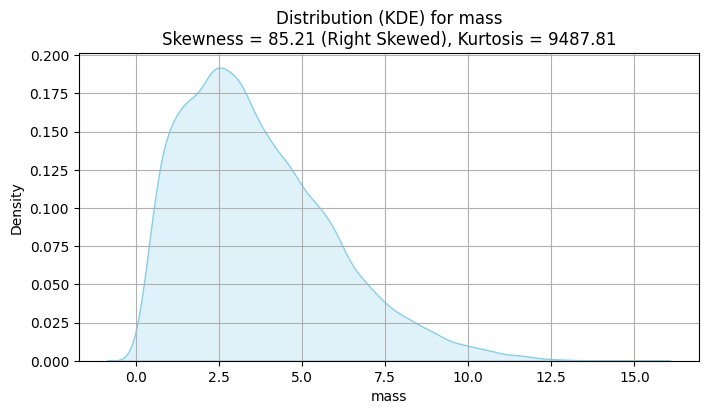

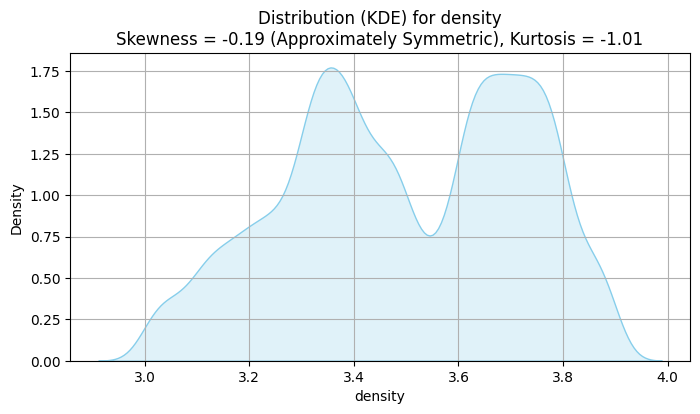

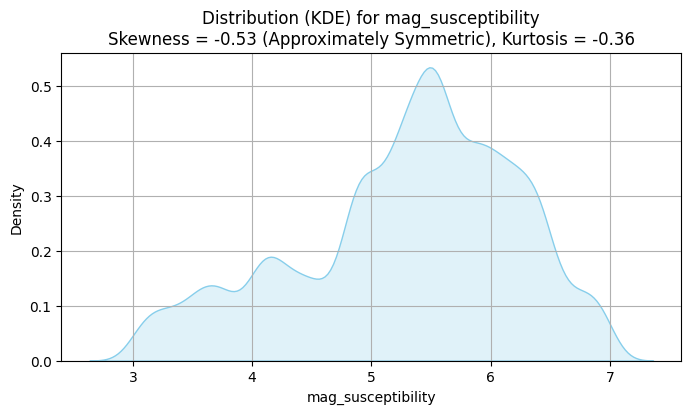

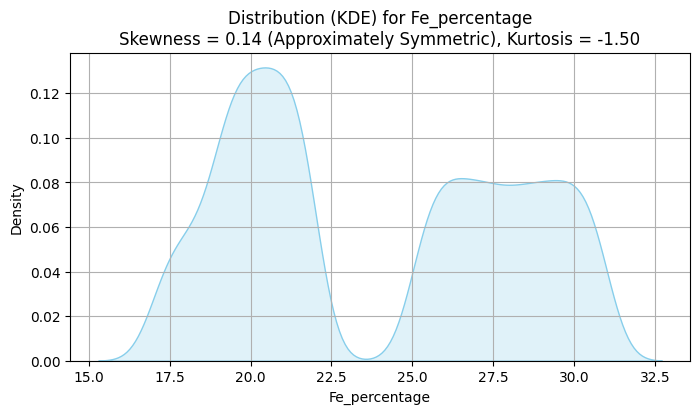

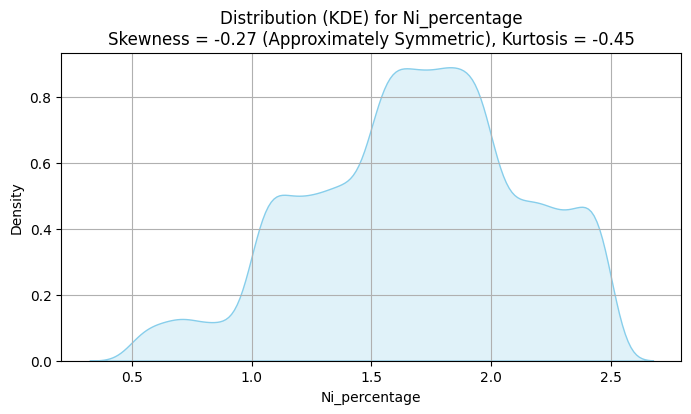

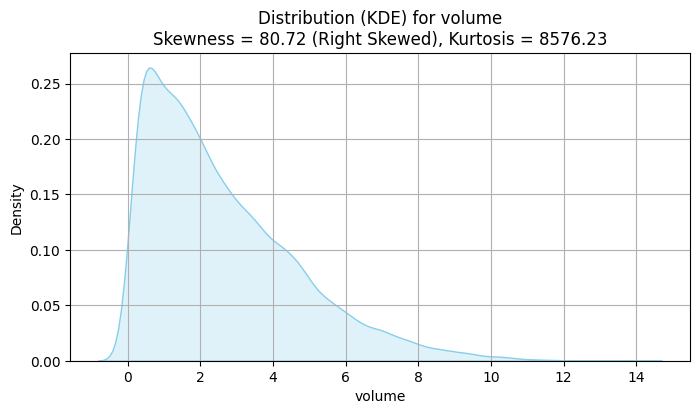

In [ ]:
#يتم استخدامه بدل الهيستوجرام عندما اركز علي حاجة معينة زي القمة او الذيل
#kortisis -  برسمه عشان اشوف توزيع الداتا
#اشوف فيه قيم متطرفة ولا لا
#اذا اكبر من 3 قيم متطرفة كتير
#اذا اقل يبقي اغلب القيم تمام
for col in numeric_cols:
  #بحسبهم تاني عشان اكتبهم علي الرسمة
  skew_val = df[col].skew()
  kurt_val = kurtosis(df[col], fisher=True)
  #بحدد ابعاد الرسمة
  plt.figure(figsize=(8, 4))
  #عشان يبقي التوزيع واضح اكتر باخد اللوغغاريتم للعمودين دول بس
  if col == "mass" or col =="volume":
    #برسم التوزيع
    sns.kdeplot(np.log1p(df[col].dropna()), fill=True, color='skyblue')
  else:
    #برسم التوزيع
    sns.kdeplot(df[col].dropna(), fill=True, color='skyblue')
  #عنوان الرسمة
  plt.title(f'Distribution (KDE) for {col}\nSkewness = {skew_val:.2f} ({skew_type(skew_val)}), Kurtosis = {kurt_val:.2f}')
  #بحدد اي اللي يكتب علي محور س و ص
  plt.xlabel(col)
  plt.ylabel('Density')
  plt.grid(True)
  plt.show()
  print("\n")


# **Histogram**

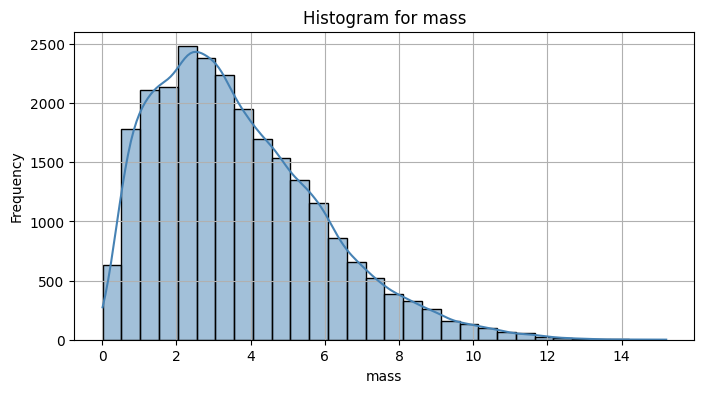

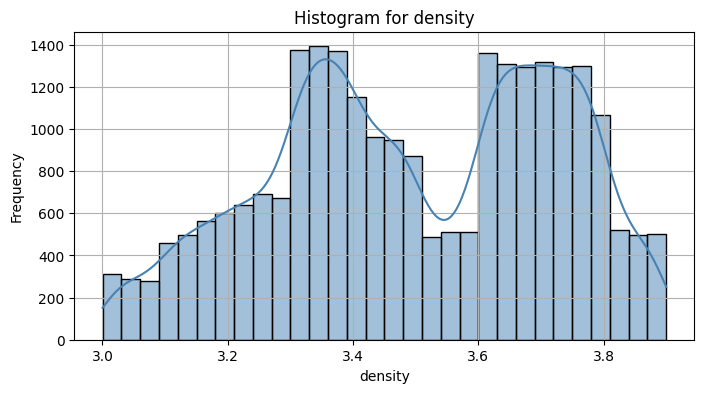

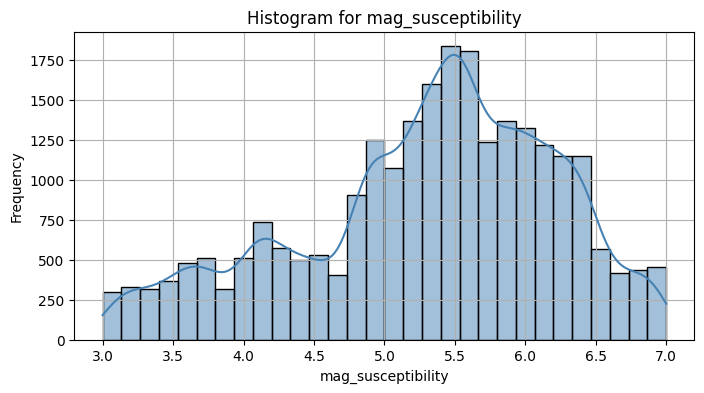

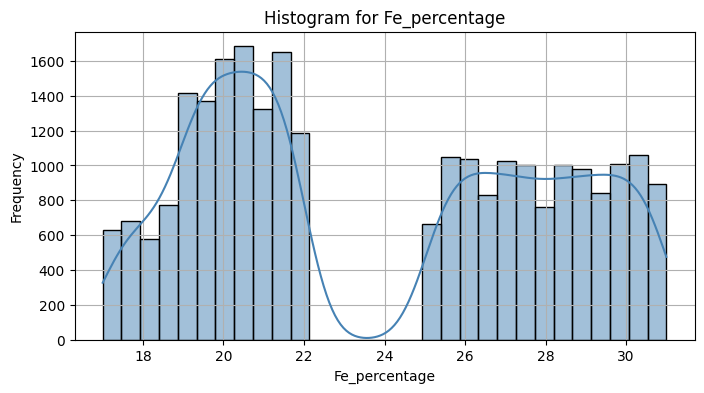

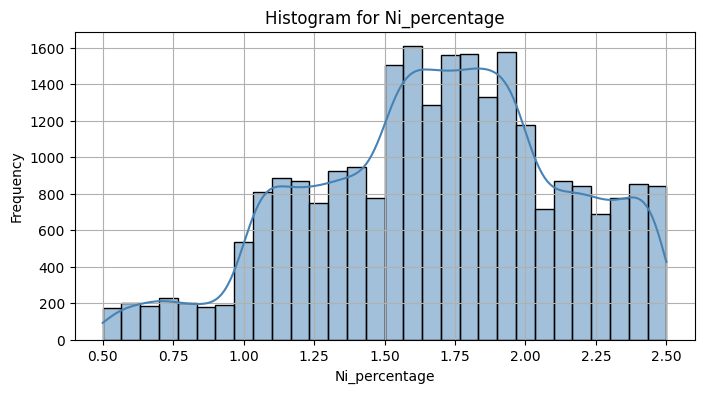

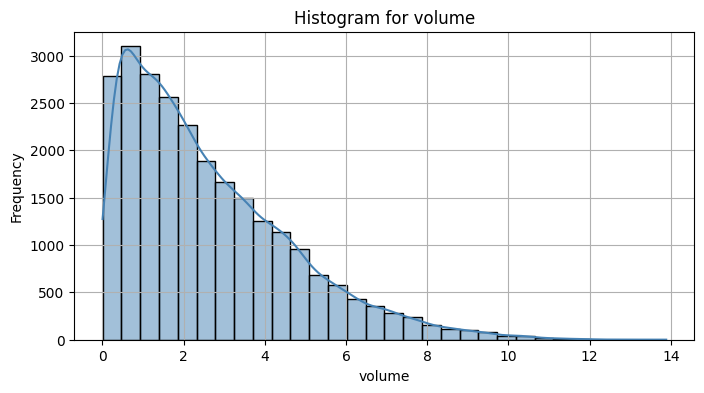

In [ ]:
#يتم استخدامه بدل الكورتيتيس لما عايزة اركز علي التوزيع كله
#histogram - برسمه عشان اشوف توزيع الداتا
# اشوف اذا skewed
for col in numeric_cols:
  #ابعاد الرسمة
  plt.figure(figsize=(8, 4))
  #عشان يبقي التوزيع واضح اكتر باخد اللوغغاريتم للعمودين دول بس
  if col == "mass" or col == "volume":
    #برسم
    #بقسم التوزيع علي 30 صندوق
    sns.histplot(np.log1p(df[col].dropna()), bins=30, kde=True, color='steelblue', edgecolor='black')

  else:
    #برسم
    #بقسم التوزيع علي 30 صندوق
    sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue', edgecolor='black')
  #عنوان
  plt.title(f'Histogram for {col}')
  #اي اللي يكتب علي س وص
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()
  print("\n")


# **Boxplot**

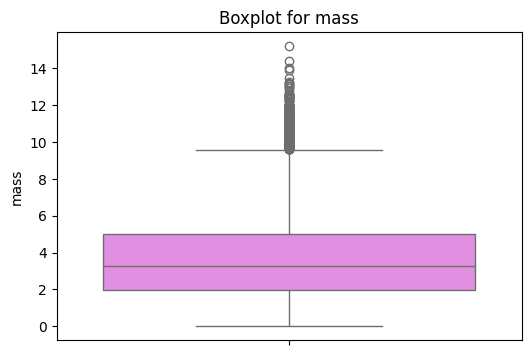

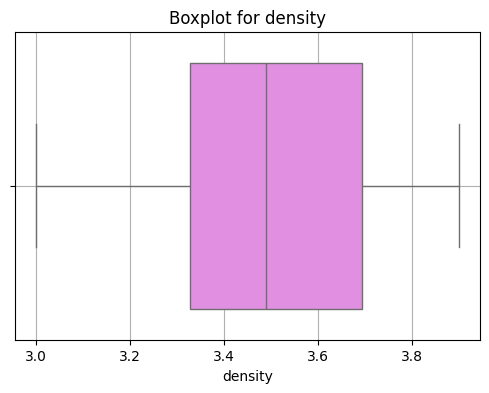

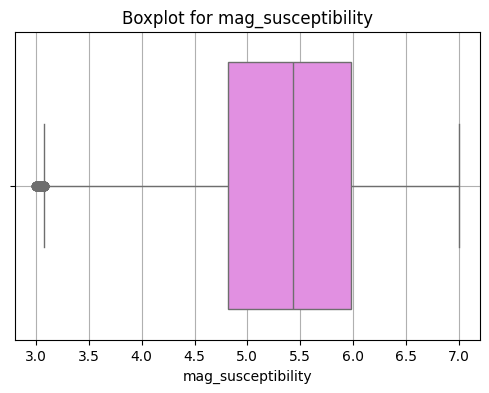

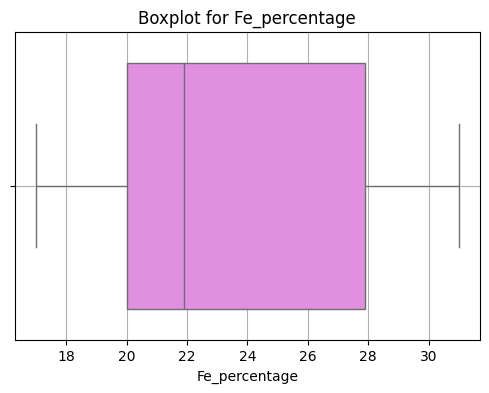

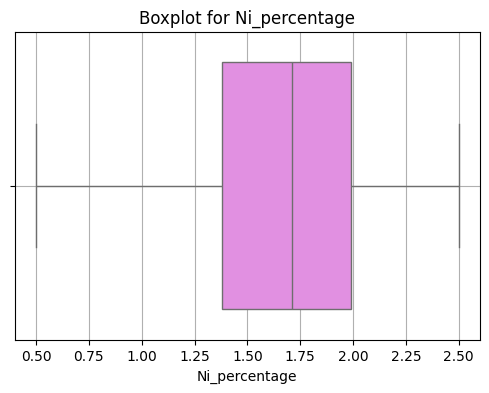

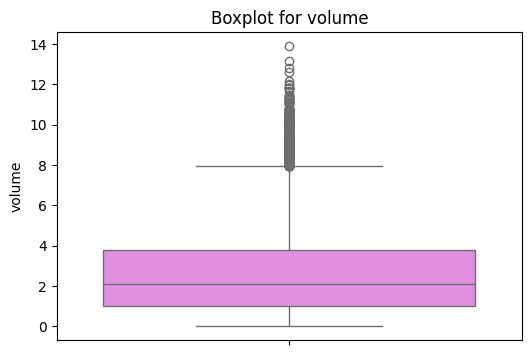

In [ ]:
#بقسم الداتا هنا الي خمس قيم اعلي واصغر والنصف والربع والتلت اربع
#بشوف اذا فيه قيم متطرفة ولا لا  عن طريق النقط
#لو خط المتوسط مش ف المنتصف يبقي skewed
#الدواير خارج الصندوق هي القيم المتطرفة
#الخط اللي بداخل الصندوق هي المتوسط
#لما يكزن الخط قريب من الالسفل يبقي right skewed
#والعكس صحيح
#بمشي علبي كل عمود احسبه
for col in numeric_cols:
  #ابعاد الرسمة
    plt.figure(figsize=(6, 4))
    #عشان يبقي التوزيع واضح اكتر باخد اللوغغاريتم للعمودين دول بس
    if col =="mass" or col =="volume":
      #برسمه
      sns.boxplot(np.log1p(df[col].dropna()), color='violet')
      plt.title(f'Boxplot for {col}')
    else:
      #برسمه
      sns.boxplot(x=df[col].dropna(), color='violet')
      plt.title(f'Boxplot for {col}')
      plt.xlabel(col)
      plt.grid(True)
      plt.show()
      print("\n")

# **Correlation Matrix**

Covariance:
                             mass    density  mag_susceptibility  \
mass                1.064575e+09  42.768042           56.970484   
density             4.276804e+01   0.050739            0.187763   
mag_susceptibility  5.697048e+01   0.187763            0.845109   
Fe_percentage       4.458697e+02   0.837333            3.136468   
Ni_percentage       7.055265e+01   0.069661            0.275170   
volume              2.943675e+08   6.135520           -4.188632   

                    Fe_percentage  Ni_percentage        volume  
mass                   445.869666      70.552651  2.943675e+08  
density                  0.837333       0.069661  6.135520e+00  
mag_susceptibility       3.136468       0.275170 -4.188632e+00  
Fe_percentage           18.577579       1.344457  2.250435e+01  
Ni_percentage            1.344457       0.199156  1.168243e+01  
volume                  22.504350      11.682427  8.160002e+07  


Correlation:
                         mass   density  mag_su

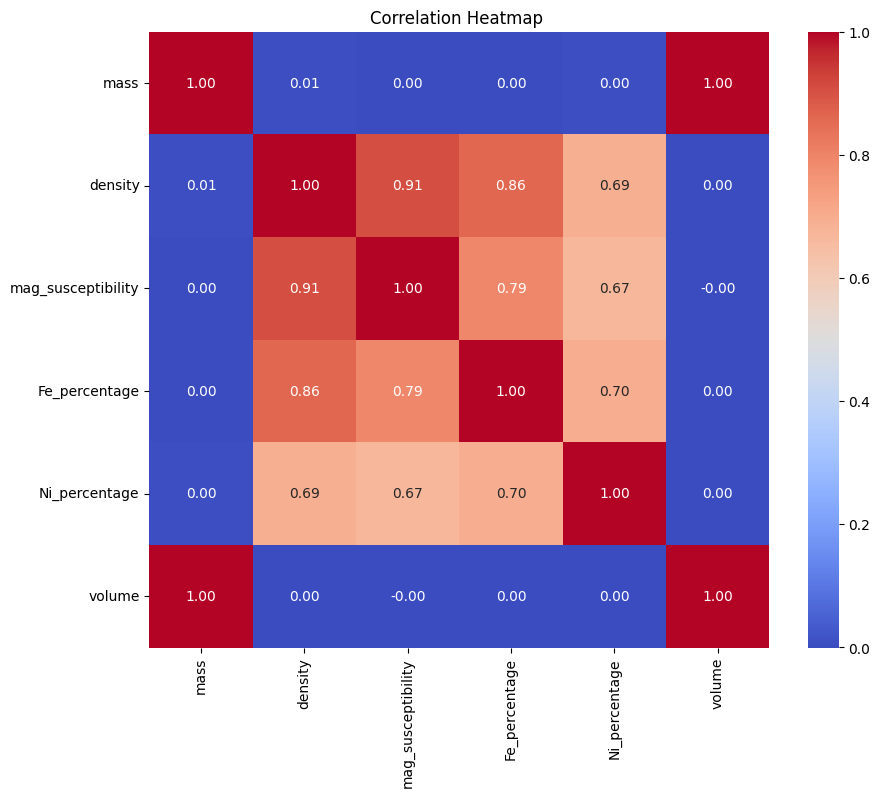

In [ ]:
#covariance --> بشوف علاقتهم طردية ام عكسية اصلا
covariance_clean = df[numeric_cols].cov()
print("Covariance:\n", covariance_clean)
print("\n")

#Correlation
#بشوف بقا مقدار قوة العلاقة هي قوية اوي وسط ضعيفة
numeric_colls = ['mass','density', 'mag_susceptibility', 'Fe_percentage', 'Ni_percentage','volume']
#بحسبه
correlation_clean = df[numeric_colls].corr()
print("Correlation:\n", correlation_clean)
#ابعاد الرسمة
plt.figure(figsize=(10, 8))
#برسمه
#anot - > اكتب الارقام داخلها
#cmap - >الالوان احمر طردية ازرق عكسية وكل ما يغمق كل ما العلاقة اقوي
#fmt - > 2 ديجيت للعلامة العشرية
sns.heatmap(correlation_clean, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap ')
plt.show()



## **Linear Regression**

# **الداتا عندنا discrete**
# **لذلك الموديل هنا بيعمل كلاسترز طبعا دا مش انسب حاجة للداتا بتاعتنا ولكن حطيناه ف البروجكت لان حضرتك شرحتيه في اخر محاضرة**
# **بنتنبأ هنا خاصية علي اساس خاصية تانية**

R-squared (regression): 0.7438197068273718


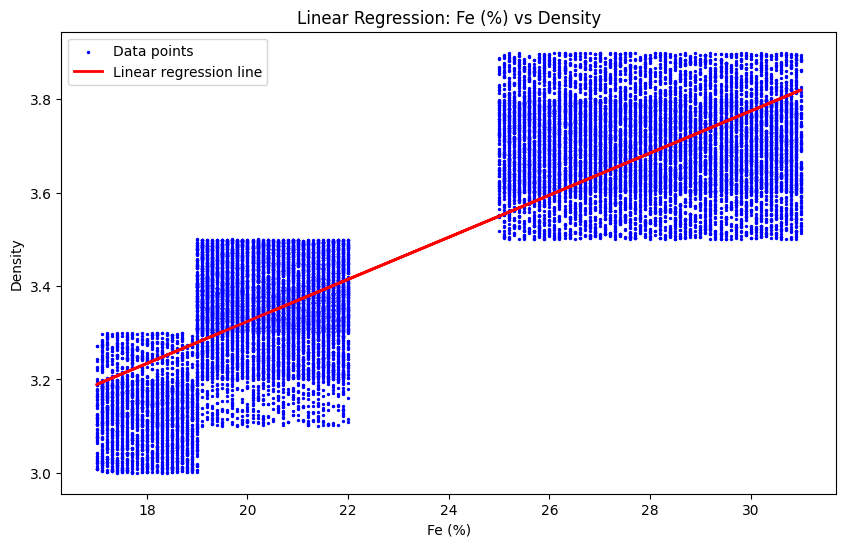

In [ ]:
#بحدد الخواص اللي عيزاها
#هنا اختارت نسبة الحديد والكثافة
X = df['Fe_percentage'].values.reshape(-1, 1)
y = df['density'].values
#normilzation z score - عشان اشيل القيم المتطرفة
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#بجهز الداتا وبعملها علي هيئة فيكتور عاشن الموديل يشتغل عليها
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
#بستدعي الموديل
model = LinearRegression()
#هنا بدخل القيم الموديل عشان يتدرب عليها ويعمل باترن
#بيبدا training
model.fit(X_scaled, y_scaled)
#يتنبيء
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#بيحسب دقة الموديل
r2 = r2_score(y, y_pred)
print("R-squared (regression):", r2)
#بحدد الابعاد بتاعت الرسمة
plt.figure(figsize=(10, 6))
#برسم الداتا
plt.scatter(X, y, color='blue', s=2, label='Data points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear regression line')
#بكتب علي المحاور الاسماء
plt.xlabel('Fe (%)')
plt.ylabel('Density')
plt.title('Linear Regression: Fe (%) vs Density')
plt.legend()
plt.show()

R-squared (regression): 0.4802233319325919


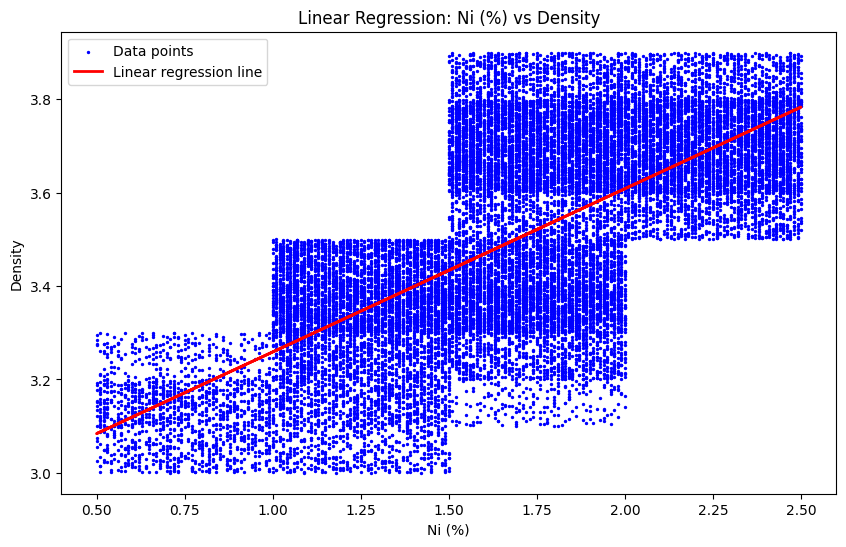

In [ ]:
#بحدد الخواص اللي عيزاها
#هنا اختارت نسبة النيكل والكثافة
X = df['Ni_percentage'].values.reshape(-1, 1)
y = df['density'].values
#normilzation z score - عشان اشيل القيم المتطرفة
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#بجهز الداتا وبعملها علي هيئة فيكتور عاشن الموديل يشتغل عليها
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
#بستدعي الموديل
model = LinearRegression()
#هنا بدخل القيم الموديل عشان يتدرب عليها ويعمل باترن
#بيبدا training
model.fit(X_scaled, y_scaled)
#يتنبيء
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#بيحسب دقة الموديل
r2 = r2_score(y, y_pred)
print("R-squared (regression):", r2)
#بحدد ابعاد الرسمة
plt.figure(figsize=(10, 6))
#برسم الداتا والخط
plt.scatter(X, y, color='blue', s=2, label='Data points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear regression line')
plt.xlabel('Ni (%)')
plt.ylabel('Density')
plt.title('Linear Regression: Ni (%) vs Density')
plt.legend()
plt.show()

# **دي طالعة كويسة**

R-squared (regression): 0.9975007407498261


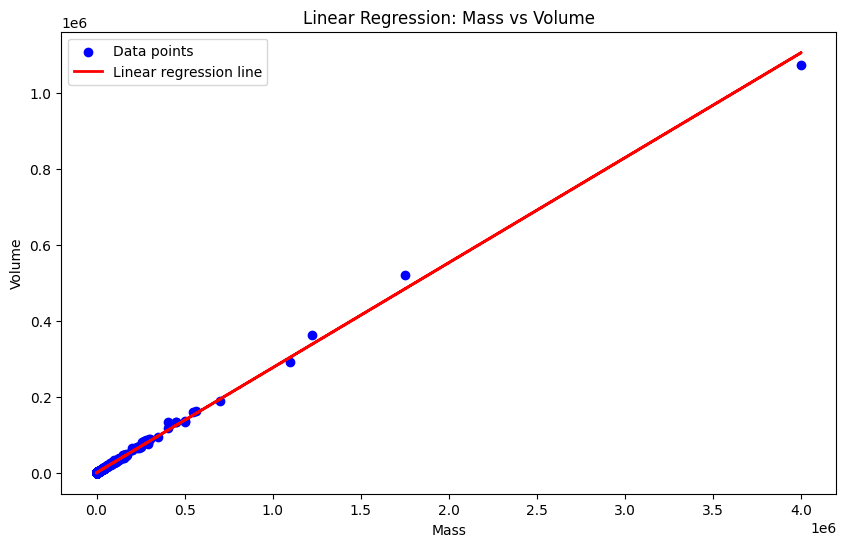

In [ ]:
#بحدد الخواص اللي عيزاها
#هنا اختارت نسبة الكتلة والكثافة
X = df['mass'].values.reshape(-1, 1)
y = df['volume'].values
#normilzation z score - عشان اشيل القيم المتطرفة
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#بجهز الداتا وبعملها علي هيئة فيكتور عاشن الموديل يشتغل عليها
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
#بستدعي الموديل
model = LinearRegression()
#هنا بدخل القيم الموديل عشان يتدرب عليها ويعمل باترن
#بيبدا training
model.fit(X_scaled, y_scaled)
#يتنبيء
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#بيحسب دقة الموديل
r2 = r2_score(y, y_pred)
print("R-squared (regression):", r2)
#بحدد ابعاج الرسمة
plt.figure(figsize=(10, 6))
#برسم الداتا والخط
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear regression line')
plt.xlabel('Mass')
plt.ylabel('Volume')
plt.title('Linear Regression: Mass vs Volume')
plt.legend()
plt.show()

## **Prediction Model for Classification**

In [ ]:
df = pd.read_csv('finalMetoer.csv')
#هنا عندي الكلاس بحوله لقيم رقمية عشان الموديل يعرف يتعامل معاه
label_encoder_class = LabelEncoder()
df["recclass"] = label_encoder_class.fit_transform(df["recclass"])
#بستدعي الخواص اللي هنصف ع اساسها
#وتبقي خواص بتاثر فعلا بشكل علمي وفعلي مش اي خاصية وخلاص
X = df[["fell_found", "density", "mag_susceptibility", "Fe_percentage", "Ni_percentage", "mass"]]
#بختار الخاصية اللي عيزاه ينتيء بيها
y = df["recclass"]
#normalizations z score - بعمله عشان اشيل القيم المتطرفة والتنبيء يبقي صح
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
#بحول الداتا من اراي الي داتافريم تاني
X = pd.DataFrame(X_normalized, columns=X.columns, index=X.index)
#بستخدمها عشان انا عندي عدم توازن في الداتا
#انا عندي الكلاسز بينهم فروق كبيرة في العدد
#الحل: ان الدالة دي بتروح للكلاسز اللي عدد عناصرها قليل بختار قيمة فيهم
#القيمة دي بروح لبعض جيرانها اجيب المتوسط لخواصهم وعلي اساسه
#اولد داتا وهمية تخلي عدد العناصر في الكلاسز متساوي
#42 عشان يبقي يطلع نفس الداتا كل مرة
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
#هنا بخلي 20 testing
#80 training
#42 random state عشان يبقي يطلع نفس الداتا كل مرة
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)
#بجهز الموديل
#ليه اخترته ؟ لانه بيشتغل علي الداتا المعقدة كويس اوي
#accuracy بيطلعها عالية
#بيشتغل علي non linear data
#بيشتغلي ازاي؟ انا بحدد عدد معين من الاشجار كل شجرة بعطيها خواص معينة تتدرب عليها مختلفة عن الاشجار التانية
#بعدين بعمل تثثويت اشوف كل شجرة تتوقع ان دا كلاس اي واخد بالاغلبية
model = RandomForestClassifier(
    n_estimators=200,#عدد الاشجار
    max_depth=25,#اكبر عمق 25 ليفل
    min_samples_split=5,#اقل عدد سامبلز عشان النود تتفرع اكتر
    min_samples_leaf=3,#اقل عدد سامبلز لل leaf
    random_state=42,
    class_weight="balanced"#weight-> احاول اعطي وزن علي حسب كمية كل كلاس عشان
    #اعمل balance
    #لان عدد الكلاسز مش متساوي عندي
    #weight + smote -- > سوا بيعملوا اداء افضل في حل مشكلة عدم تساوي الاعداد داخل كل كلاس
)
#ببدأ training
#ويكون باترن
model.fit(X_train, y_train)
#بيتنيء
y_pred = model.predict(X_test)
#بحسب الاكيوريسي بتاعت الموديل
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy (All Classes): {accuracy:.2f}")
#بدخله سامبل يصنفها
new_data = pd.DataFrame([[1, 0.003, 3.5, 2, 4, 500]],
                        columns=["fell_found", "density", "mag_susceptibility", "Fe_percentage", "Ni_percentage", "mass"])
new_data_scaled = scaler.transform(new_data)
new_data = pd.DataFrame(new_data_scaled, columns=X.columns)
predicted_class = model.predict(new_data)
print(f"Predicted Meteor Class: {label_encoder_class.inverse_transform(predicted_class)}")


Model Accuracy (All Classes): 0.94
Predicted Meteor Class: ['LL5']


# **Confusion Matrix**

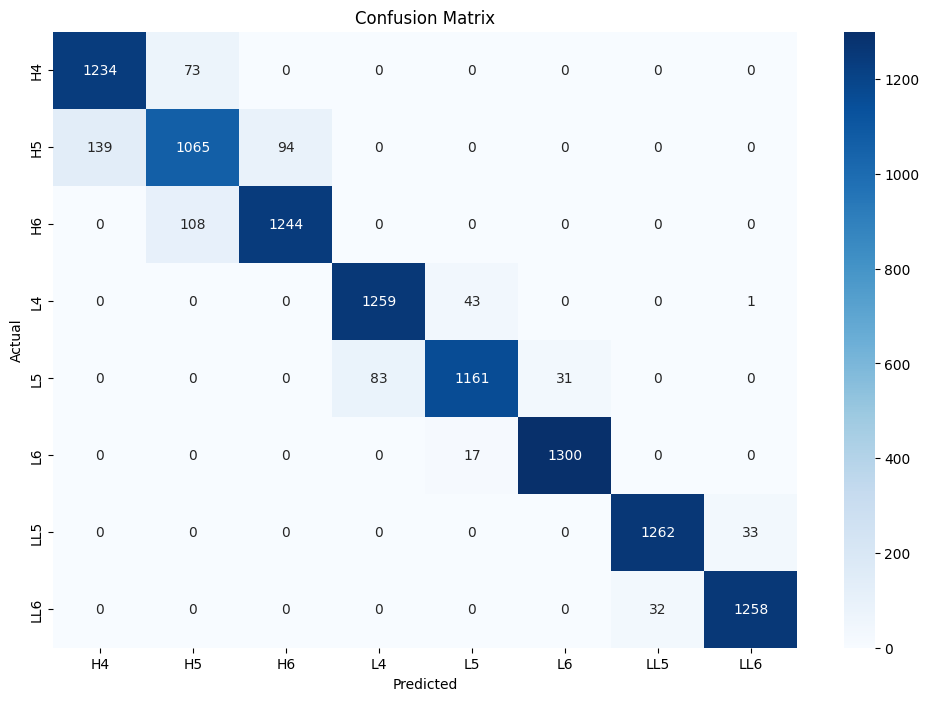

In [ ]:
#بجيبها عشان اشوف اداء الموديل وهل في كلاس معين دايما بيطلع غلط مثلا
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_class.classes_,
            yticklabels=label_encoder_class.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **ANOVA Hypothesies Testing**

# **Hypothesis Testing**
**Hypothesis:** Does mass affect the meteorite classification?

**Null Hypothesis (H₀):** The mean mass of meteorites is the same across all classes (mass does not affect classification).

**Alternative Hypothesis (H₁)**:The mean mass of meteorites differs between at least two classes (mass affects classification).

In [ ]:
df=pd.read_csv('finalMetoer.csv')
#اخترنا الانوفا لانه بيشتغر علي اكثر من كلاس
#بجيب كل الكتلة لكل كلاس
class_1 = df[df['recclass'] == 'L6']['mass']
class_2 = df[df['recclass'] == 'H5']['mass']
class_3 = df[df['recclass'] == 'L5']['mass']
class_4 = df[df['recclass'] == 'H6']['mass']
class_5 = df[df['recclass'] == 'H4']['mass']
class_6 = df[df['recclass'] == 'LL5']['mass']
class_7 = df[df['recclass'] == 'LL6']['mass']
class_8 = df[df['recclass'] == 'L4']['mass']
#بعمل التيست عن طريق اني اجيب المتوسط بتاع كل واحدة فيهم واشوف اذا فيه فرق ام لا
t_stat, p_value = f_oneway(class_1, class_2,class_3,class_4,class_5,class_6,class_7,class_8)
print("T-statistic:", t_stat)
print("P-value:", p_value)
#بحدد قيمة الفا
alpha = 0.05
#علي حسب قيمة ال p بحدد اذا برفض ام عاجز عن الرفص
if p_value < alpha:
    print("Reject the null hypothesis: The mass affects classification.")
else:
    print("Fail to reject the null hypothesis: The mass does not significantly affect classification.")

T-statistic: 1.7338554023202055
P-value: 0.09619763991275912
Fail to reject the null hypothesis: The mass does not significantly affect classification.


# **Two Tailed distribution**

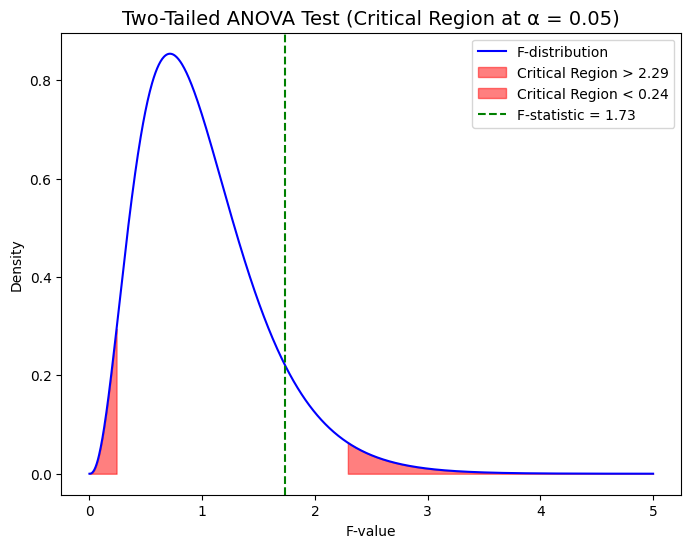

Fail to reject the null hypothesis: The mass does not significantly affect classification.


In [ ]:
alpha = 0.05
df= pd.read_csv('finalMetoer.csv')
#degrees of freedom between groups قانون
# 8 - 1
#عدد الكلاسز - عدد الجروب الللي ببني عليه الهيبوسيزيس
dfn = 7
#degrees of freedom within groups)
#بتتحسب عن طريق عدد الداتا - عدد الكلاسز
dfd = len(df) - 8
#بحسب المنطقة الحرجة
f_critical = f.ppf(1 - alpha / 2, dfn, dfd)
#بعمل التيست
# f = varaince between groups / variance within groups
f_stat, p_value = f_oneway(class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8)
x = np.linspace(0, 5, 1000)
y = f.pdf(x, dfn, dfd)

#برسم
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='F-distribution', color='b')
plt.fill_between(x, y, where=(x > f_critical), color='r', alpha=0.5, label=f'Critical Region > {f_critical:.2f}')
plt.fill_between(x, y, where=(x < f.ppf(alpha / 2, dfn, dfd)), color='r', alpha=0.5, label=f'Critical Region < {f.ppf(alpha / 2, dfn, dfd):.2f}')
plt.axvline(x=f_stat, color='g', linestyle='--', label=f'F-statistic = {f_stat:.2f}')
plt.title(f"Two-Tailed ANOVA Test (Critical Region at α = {alpha})", fontsize=14)
plt.xlabel("F-value")
plt.ylabel("Density")
plt.legend()
plt.show()
if p_value < alpha:
    print("Reject the null hypothesis: The mass affects classification.")
else:
    print("Fail to reject the null hypothesis: The mass does not significantly affect classification.")


# **Classifcation model after removing mass**

## نتيجة الفرض بتاعنا ان الكتلة لا  تؤثر علي التصنيف فعشان كدا شيلناها من الموديل وطلعت فعلا لا تؤثر والاكيوريسي زي ما هي


In [ ]:
df = pd.read_csv('finalMetoer.csv')
label_encoder_class = LabelEncoder()
df["recclass"] = label_encoder_class.fit_transform(df["recclass"])
X = df[["fell_found", "density", "mag_susceptibility", "Fe_percentage", "Ni_percentage"]]
y = df["recclass"]
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = pd.DataFrame(X_normalized, columns=X.columns, index=X.index)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy (All Classes): {accuracy:.2f}")
new_data = pd.DataFrame([[1, 0.003, 3.5, 2, 4]],
                        columns=["fell_found", "density", "mag_susceptibility", "Fe_percentage", "Ni_percentage"])
new_data_scaled = scaler.transform(new_data)
new_data = pd.DataFrame(new_data_scaled, columns=X.columns)
predicted_class = model.predict(new_data)
print(f"Predicted Meteor Class: {label_encoder_class.inverse_transform(predicted_class)}")


Model Accuracy (All Classes): 0.94
Predicted Meteor Class: ['LL5']


# **Geolocation Diagram**

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


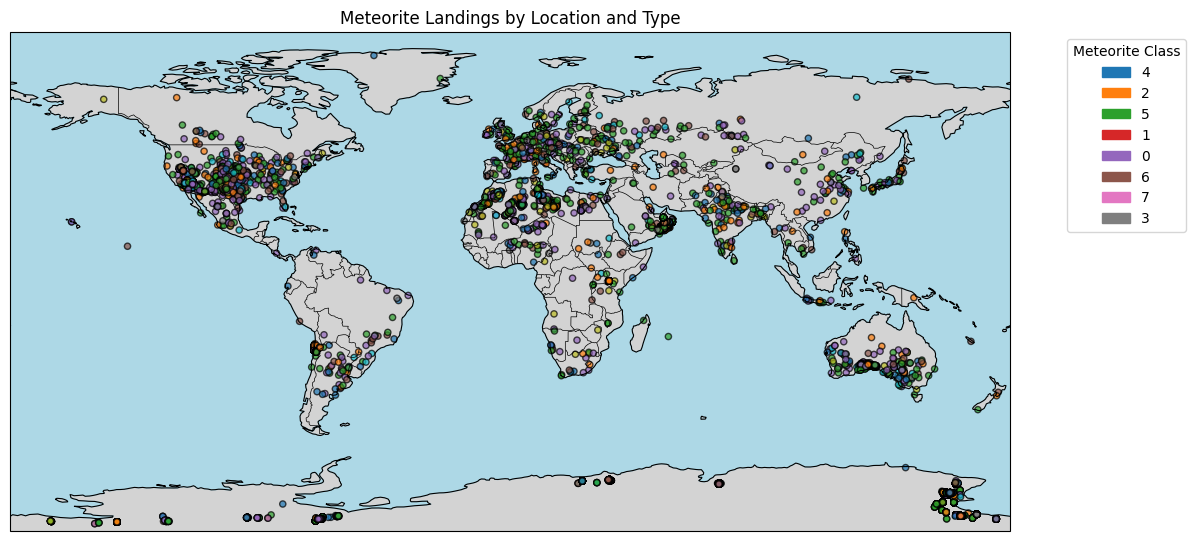

In [ ]:
#بجيب الاحداثيات
latitudes = df["reclat"].values
longitudes = df["reclong"].values
#بعمل للكلاسز انكودينج
classes, class_names = pd.factorize(df["recclass"])
#بحدد ابعاد الرسمة
fig = plt.figure(figsize=(12, 6))
#رسم الخريطة
ax = plt.axes(projection=ccrs.PlateCarree())
#بخلي الحدود بخط عرضه 0.8
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
#رسم الحدود بين الدول بخط مقاسه 0.5
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#بخلي الارض لونها رمادي
ax.add_feature(cfeature.LAND, color="lightgray")
#البحار والمحيطات لبني
ax.add_feature(cfeature.OCEAN, color="lightblue")
sc = ax.scatter(
    longitudes, latitudes, c=classes, cmap="tab10", alpha=0.7,
    edgecolors="black", s=20, transform=ccrs.PlateCarree()
)
#برسم النيازك
#alpha شفافية النقطة
#cmap اللون
cmap = plt.get_cmap("tab10")
unique_class_ids = np.unique(classes)
handles = [
    mpatches.Patch(color=cmap(i % 10), label=class_names[i])
    for i in unique_class_ids
]
plt.legend(handles=handles, title="Meteorite Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Meteorite Landings by Location and Type")
plt.tight_layout()
plt.show()


# **Fell VS Found**

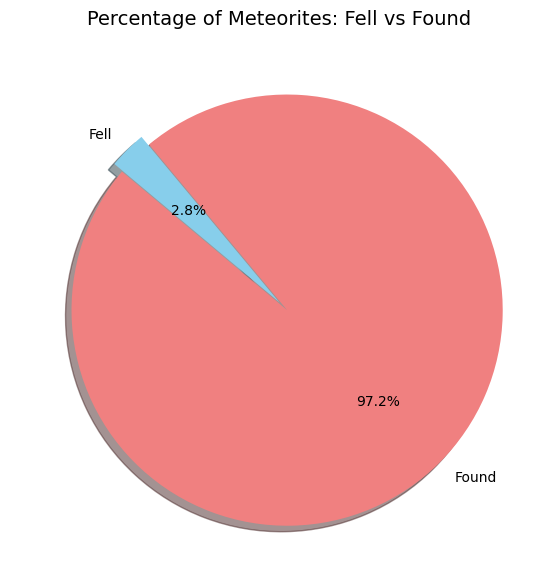

In [ ]:
#بشوف نسبة النيازك اللي وجدت بالصدفة بالنسبة للنيازك اللي تم مراقبة وتوقع سقوطها
#بجيب القيم في العمود دا هي اي وكل قسمة منهم اتكررت كام مرة
fall_counts = df["fall"].value_counts()
labels = fall_counts.index
values = fall_counts.values
#بحدد الالوان
colors = ["lightcoral", "skyblue"]
#بحدد الابعاد
plt.figure(figsize=(7, 7))
#برسم
#startangle- > ببدأ من زايوة كام
#autopct--> فورمات الرقم كام علامة عشرية مثلا
plt.pie(values, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140, shadow=True, explode=[0.05, 0])
plt.title("Percentage of Meteorites: Fell vs Found", fontsize=14)
plt.show()


# **Meteor Per Contienent**

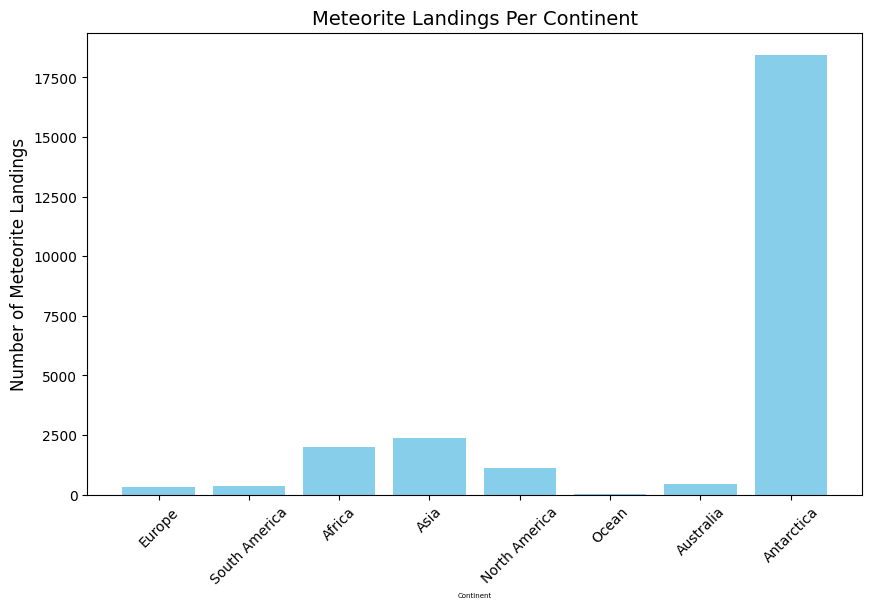

In [ ]:
#بشوف اللوكيشن بتاع كل نيزك وعلي اساسه بحدد اذا وقع في قارة اي او وقع في البحر
def classify_continent(lat, lon):
    if -90 <= lat <= -60:
        return "Antarctica"
    elif 7 <= lat <= 83 and -168 <= lon <= -52:
        return "North America"
    elif -56 <= lat <= 13 and -81 <= lon <= -34:
        return "South America"
    elif 35 <= lat <= 71 and -25 <= lon <= 60:
        return "Europe"
    elif -35 <= lat <= 37 and -17 <= lon <= 51:
        return "Africa"
    elif 10 <= lat <= 81 and 25 <= lon <= 180:
        return "Asia"
    elif -50 <= lat <= 0 and 110 <= lon <= 180:
        return "Australia"
    else:
        return "Ocean"

#بشوف كل نيزك وقع فين
df["continent"] = df.apply(lambda row: classify_continent(row["reclat"], row["reclong"]), axis=1)
#بتجيب عدد ظهور كل قارة
continent_counts = Counter(df["continent"])
#بحدد ابعاد الرسم
plt.figure(figsize=(10,6))
#برسم
plt.bar(continent_counts.keys(), continent_counts.values(), color="skyblue")
plt.xlabel("Continent",fontsize=5)
plt.ylabel("Number of Meteorite Landings",fontsize=12)
plt.title("Meteorite Landings Per Continent",fontsize=14)
plt.xticks(rotation=45)
plt.show()


# **Each Metoer Percentage**

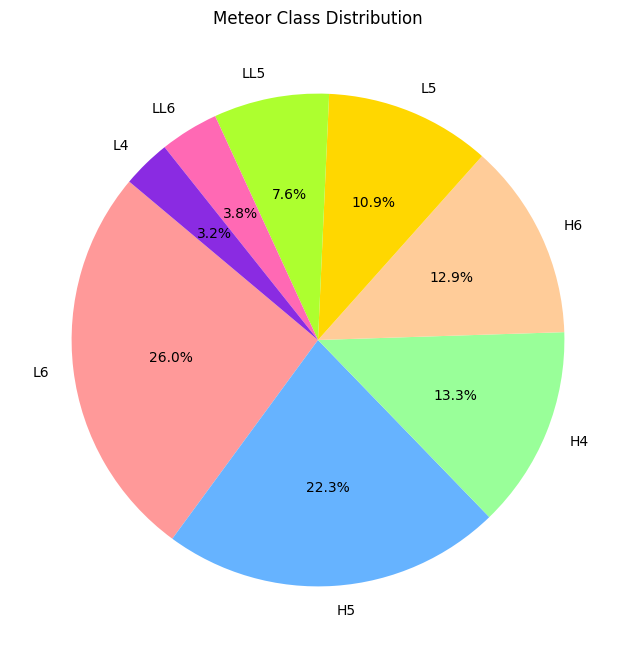

In [ ]:
#بشوف كل كلاس نسبته اي
#بجيب عدد ظهور كل كلاس
meteor_counts = df["recclass"].value_counts()
#بحدد الكلاسز
target_classes = ["L6", "H5", "L5", "H6", "H4", "LL5", "LL6", "L4"]
#بحدد الالوان
colors = ["#FF9999", "#66B3FF", "#99FF99", "#FFCC99", "#FFD700", "#ADFF2F", "#FF69B4", "#8A2BE2"]
#بحدد الابعاد وارسم
plt.figure(figsize=(8, 8))
plt.pie(meteor_counts, labels=meteor_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Meteor Class Distribution")
plt.show()
